## Start
<a id='top'>Top reference</a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import (
    Binarizer,
    StandardScaler,
    LabelBinarizer,
    OneHotEncoder,
)
from sklearn.linear_model import LogisticRegression
from sklearnex import patch_sklearn

patch_sklearn()
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.neural_network import MLPClassifier
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

sns.set()
pd.options.display.max_columns = 50
# pd.options.plotting.backend = "plotly"
from sklearn import set_config

set_config(display="diagram")
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import warnings
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore")
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
    GradientBoostingClassifier,
)
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    StratifiedGroupKFold,
    StratifiedKFold,
)

In [2]:
%reload_ext sigopt
%sigopt config

SigOpt API token (find at https://app.sigopt.com/tokens/info):

  ················································


Log Collection
	This will capture and upload the standard output and standard error of your
	Runs from the CLI and notebook cells so that you can view them on the SigOpt dashboard.
Enable log collection [y/N]:

  y


Notebook Cell Tracking
	This will record and upload the content of your notebook cells so that you can view them
	on the SigOpt dashboard.
Enable cell tracking [y/N]:

  y


In [ ]:
cat_col = [
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
]

In [3]:
dtype_info = {
    "v_1": "Binary",
    "v_26": "Binary",
    "v_11": "Binary",
    "v_14": "Binary",
    "v_30": "Binary",
    "v_28": "Binary",
    "v_9": "Binary",
    "v_27": "Binary",
    "v_32": "Nominal",
    "v_4": "Nominal",
    "v_3": "Nominal",
    "v_20": "Nominal",
    "v_21": "Nominal",
    "v_18": "Nominal",
    "v_25": "Nominal",
    "v_12": "Nominal",
    "v_31": "Ordinal",
    "v_15": "Ordinal",
    "v_19": "Ordinal",
    "v_13": "Ordinal",
    "v_33": "Ordinal",
    "v_17": "Ordinal",
    "v_29": "Ordinal",
    "v_23": "Ordinal",
    "v_6": "Ordinal",
    "v_24": "Ordinal",
    "v_10": "Ordinal",
    "v_5": "Ordinal",
    "v_22": "Ordinal",
    "v_0": "Ordinal",
    "v_16": "Ratio",
    "v_2": "Ratio",
    "v_8": "Ratio",
    "v_7": "Ratio",
    "v_39": "Ratio",
    "v_37": "Ratio",
    "v_38": "Ratio",
    "v_34": "Ratio",
    "v_40": "Ratio",
    "v_36": "Ratio",
    "v_35": "Ratio",
}
sorted(dtype_info)

data = pd.read_pickle("../data/train.pkl")
prediction_data = pd.read_pickle("../data/pred_data.pkl")

# discrete = data.select_dtypes(include="int64")
# numeric = data.select_dtypes(include="float64")

ordinal = [i for i in dtype_info if dtype_info[i] == "Ordinal"]
nominal = [i for i in dtype_info if dtype_info[i] == "Nominal"]
binary = [i for i in dtype_info if dtype_info[i] == "Binary"]
ratio = [i for i in dtype_info if dtype_info[i] == "Ratio"]


def categorise_data(data):
    ordinal_data = data.loc[:, ordinal]
    nominal_data = data.loc[:, nominal]
    binary_data = data.loc[:, binary]
    ratio_data = data.loc[:, ratio]
    return ordinal_data, nominal_data, binary_data, ratio_data


# ordinal_data, nominal_data, binary_data = categorise_data(data)
# ordinal_data.to_pickle('../data/ordinal_data.pkl')
# nominal_data.to_pickle('../data/nominal_data.pkl')
# binary_data.to_pickle('../data/binary_data.pkl')
(
    ordinal_data_test,
    nominal_data_test,
    binary_data_test,
    ratio_data_test,
) = categorise_data(prediction_data)
ordinal_data = pd.read_pickle("../data/ordinal_data.pkl")
nominal_data = pd.read_pickle("../data/nominal_data.pkl")
binary_data = pd.read_pickle("../data/binary_data.pkl")
ratio_data = pd.read_pickle("../data/ratio_data.pkl")
total_discrete = pd.read_parquet("../data/total_pickle.hdfs")

In [4]:
ode = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
)
tt_lb = data["label"]
binarizer = Binarizer()
ohe = OneHotEncoder(min_frequency=100, handle_unknown="infrequent_if_exist")
b_ohe = OneHotEncoder(min_frequency=5, handle_unknown="infrequent_if_exist")
sc = StandardScaler(with_mean=True)
cts = ColumnTransformer(
    [
        ("ratios", sc, ratio),
        ("nominal", ohe, nominal),
        ("ordinal", ode, ordinal),
        ("binary", binarizer, binary),
    ],
    n_jobs=-1,
    remainder="drop",
)
cv = StratifiedKFold()
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(["label"], axis=1), tt_lb, random_state=42, test_size=0.3
)
dtc = DecisionTreeClassifier()
# etc = ExtraTreeClassifier()
est_ = [
    RandomForestClassifier(n_jobs=-1, random_state=42, max_features=None),  # F
    ExtraTreesClassifier(n_jobs=-1, random_state=42, max_features=None),  # F
    XGBClassifier(n_jobs=-1, use_label_encoder=False,eval_metric='aucpr', objective='binary:logistic'),
    MLPClassifier(random_state=42, max_iter=1000),
    AdaBoostClassifier(base_estimator=dtc, learning_rate=0.01, random_state=42),  # F
    XGBRFClassifier(n_jobs=-1, use_label_encoder=False,eval_metric='aucpr', objective='binary:logistic'),
    HistGradientBoostingClassifier(scoring="f1_macro", max_iter=100),
    GradientBoostingClassifier(max_depth=10000000, random_state=42),  # F
]
# classification_report(

In [ ]:
workflows = []
warnings.filterwarnings("ignore")


def make_dense(g):
    return g.toarray()


from sklearn.preprocessing import FunctionTransformer

trf = FunctionTransformer(make_dense)
from joblib import parallel_backend

with parallel_backend("threading", n_jobs=-1):
    for est in est_:
        try:
            workflow = make_pipeline(cts, est)
            warnings.filterwarnings("ignore")
            ovr = OneVsRestClassifier(workflow, n_jobs=-1, verbose=1)
            ovr.fit(X_train, y_train)
        except TypeError as e:
            workflow = make_pipeline(cts, trf, est)
            ovr = OneVsRestClassifier(workflow, n_jobs=-1, verbose=1)
            ovr.fit(X_train, y_train)
            # workflow.fit(X_train, y_train)
        workflows.append(ovr)

# import pickle
# with open('../data/ovr_workflows.pkl', 'wb') as fp:
#     pickle.dump(workflows, fp)

In [ ]:
from pprint import pprint
reports = []
for workflow,est in zip(workflows, est_):
    y_pred = workflow.predict(X_test)
    # print(sd)
    print(est.__class__.__name__)
    clf_report  = classification_report(y_test, y_pred,zero_division=0,output_dict=True)
    reports.append(clf_report)
    clf_report  = classification_report(y_test, y_pred,digits=2,zero_division=0,output_dict=False)
    print(clf_report)
    print('_'*80)

*RandomForestClassifier*
```
              precision    recall  f1-score   support

           0       0.54      0.78      0.63       362
           1       0.74      0.68      0.71       561
           2       0.56      0.25      0.35       216

    accuracy                           0.63      1139
   macro avg       0.61      0.57      0.56      1139
weighted avg       0.64      0.63      0.62      1139
```
________________________________________________________________________________
*ExtraTreesClassifier*
```

              precision    recall  f1-score   support

           0       0.69      0.75      0.71       362
           1       0.76      0.85      0.81       561
           2       0.54      0.30      0.39       216

    accuracy                           0.71      1139
   macro avg       0.66      0.63      0.64      1139
weighted avg       0.70      0.71      0.70      1139
```

________________________________________________________________________________
*XGBClassifier*
```

              precision    recall  f1-score   support

           0       0.62      0.78      0.69       362
           1       0.77      0.79      0.78       561
           2       0.54      0.28      0.37       216

    accuracy                           0.69      1139
   macro avg       0.64      0.61      0.61      1139
weighted avg       0.68      0.69      0.67      1139
```

________________________________________________________________________________
*MLPClassifier*
```

              precision    recall  f1-score   support

           0       0.58      0.78      0.67       362
           1       0.75      0.65      0.69       561
           2       0.33      0.25      0.28       216

    accuracy                           0.61      1139
   macro avg       0.55      0.56      0.55      1139
weighted avg       0.61      0.61      0.61      1139
```

________________________________________________________________________________
*AdaBoostClassifier*
```
           precision    recall  f1-score   support

           0       0.55      0.57      0.56       362
           1       0.74      0.46      0.57       561
           2       0.27      0.52      0.35       216

    accuracy                           0.51      1139
   macro avg       0.52      0.52      0.49      1139
weighted avg       0.59      0.51      0.52      1139
```

________________________________________________________________________________
*XGBRFClassifier*
```
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       362
           1       0.71      0.67      0.69       561
           2       0.51      0.24      0.33       216

    accuracy                           0.61      1139
   macro avg       0.59      0.55      0.55      1139
weighted avg       0.62      0.61      0.60      1139
```

________________________________________________________________________________
*HistGradientBoostingClassifier*
```
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       362
           1       0.78      0.79      0.78       561
           2       0.53      0.29      0.37       216

    accuracy                           0.69      1139
   macro avg       0.64      0.62      0.62      1139
weighted avg       0.68      0.69      0.68      1139
```

________________________________________________________________________________
*GradientBoostingClassifier*
```
              precision    recall  f1-score   support

           0       0.53      0.72      0.61       362
           1       0.69      0.61      0.65       561
           2       0.28      0.19      0.23       216

    accuracy                           0.57      1139
   macro avg       0.50      0.51      0.50      1139
weighted avg       0.56      0.57      0.56      1139
```

________________________________________________________________________________

Complete Occupancy
```python
[0.6224758560140474
0.6997366110623354
0.5970149253731343
0.6892010535557507
0.5776997366110623]
```

In [8]:
%matplotlib inline

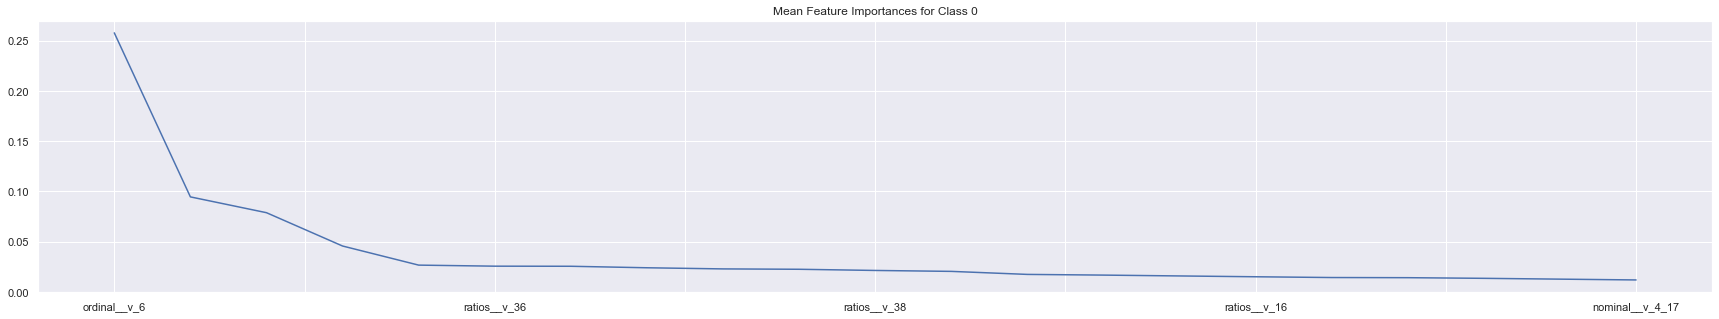

In [14]:
idx = [0, 1, 4, 7]
f_i_db = []
for _ in idx:
    f_i = workflows[_].estimators_[-3][-1].feature_importances_
    f_i_db.append(f_i)

idx = [0, 1, 4, 7]
f_i_dbname = []
for _ in idx:
    f_i = workflows[_].estimators_[-3][0].get_feature_names_out()
    f_i_dbname.append(f_i)

f_db = [dict(zip(x, y)) for x, y in zip(f_i_dbname, f_i_db)]

f_df = pd.DataFrame(f_db)

mean_f_imp_2 = f_df.mean(axis=0)
mean_f_imp_2 = mean_f_imp_2.sort_values(ascending=False)

fig = mean_f_imp_2[mean_f_imp_2>0.01].plot(kind='line', title='Mean Feature Importances for Class 0', figsize=(30,5)) 

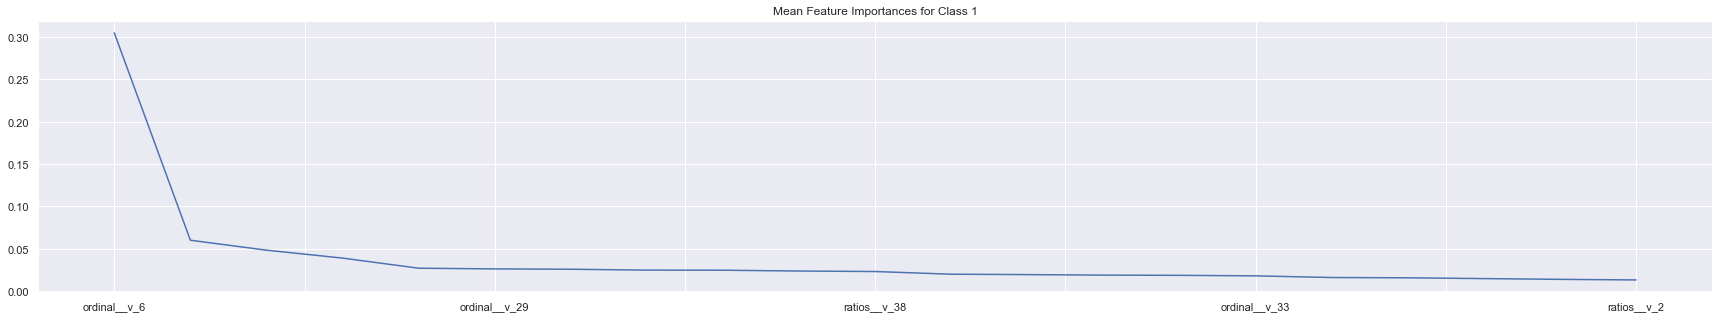

In [15]:
idx = [0, 1, 4, 7]
f_i_db = []
for _ in idx:
    f_i = workflows[_].estimators_[-2][-1].feature_importances_
    f_i_db.append(f_i)

idx = [0, 1, 4, 7]
f_i_dbname = []
for _ in idx:
    f_i = workflows[_].estimators_[-2][0].get_feature_names_out()
    f_i_dbname.append(f_i)

f_db = [dict(zip(x, y)) for x, y in zip(f_i_dbname, f_i_db)]

f_df = pd.DataFrame(f_db)

mean_f_imp_2 = f_df.mean(axis=0)
mean_f_imp_2 = mean_f_imp_2.sort_values(ascending=False)

fig = mean_f_imp_2[mean_f_imp_2>0.01].plot(kind='line', title='Mean Feature Importances for Class 1',figsize=(30,5)) 

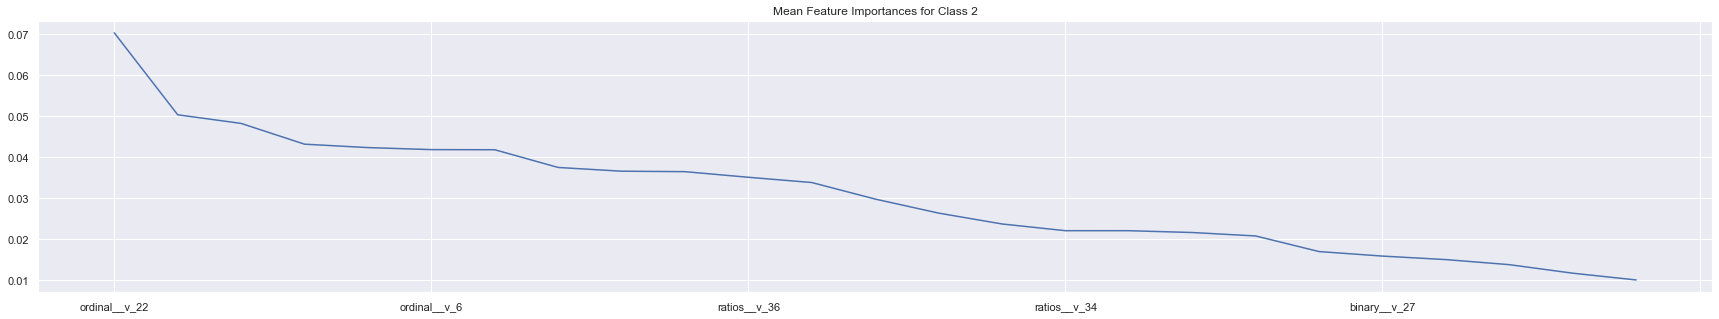

In [16]:
idx = [0, 1, 4, 7]
f_i_db = []
for _ in idx:
    f_i = workflows[_].estimators_[-1][-1].feature_importances_
    f_i_db.append(f_i)

idx = [0, 1, 4, 7]
f_i_dbname = []
for _ in idx:
    f_i = workflows[_].estimators_[-1][0].get_feature_names_out()
    f_i_dbname.append(f_i)

f_db = [dict(zip(x, y)) for x, y in zip(f_i_dbname, f_i_db)]

f_df = pd.DataFrame(f_db)

mean_f_imp_2 = f_df.mean(axis=0)
mean_f_imp_2 = mean_f_imp_2.sort_values(ascending=False)

fig = mean_f_imp_2[mean_f_imp_2>0.01].plot(kind='line', title='Mean Feature Importances for Class 2',figsize=(30,5)) 

In [63]:
ordinal_data.sort_index(axis=0, inplace=True)

In [66]:
col_ord = ['v_31', 'v_15', 'v_19', 'v_13', 'v_33', 'v_17',  'v_23', 'v_6',
       'v_24', 'v_10', 'v_5', 'v_0', 'v_22','v_29']

In [67]:
ordinal_data = ordinal_data.loc[:, col_ord]

In [84]:
ordinal_data.describe()

,v_31,v_15,v_19,v_13,v_33,v_17,v_23,v_6,v_24,v_10,v_5,v_0,v_22,v_29
count,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000
mean,32.134089,11.609062,23.562171,15.600896,30.127239,50.165701,3.975764,13.281876,16.392255,26.064015,39.934932,12.998156,24.121478,17.506418
std,7.887596,2.576362,3.757691,3.216409,3.256676,4.670733,2.249038,3.674661,2.866872,3.079682,4.507494,2.309686,5.677114,5.346593
min,25.000000,9.000000,18.000000,14.000000,23.000000,41.000000,3.000000,8.000000,15.000000,19.000000,31.000000,12.000000,13.000000,6.000000
25%,27.000000,10.000000,22.000000,14.000000,29.000000,48.000000,3.000000,11.000000,15.000000,25.000000,37.000000,12.000000,24.000000,17.200000
50%,29.000000,10.000000,24.000000,14.000000,29.000000,49.000000,3.000000,13.000000,15.000000,25.000000,39.000000,12.000000,25.500000,18.571429
75%,35.000000,12.000000,25.000000,16.000000,31.000000,53.000000,3.000000,15.000000,16.000000,27.000000,42.000000,12.000000,27.000000,20.000000
max,78.000000,25.000000,45.000000,38.000000,49.000000,86.000000,17.000000,28.000000,37.000000,42.000000,64.000000,26.000000,38.000000,31.111111


In [102]:
# ordinal_data
from collections import OrderedDict
c = OrderedDict()
for col in ordinal:
    c[col] = total_discrete[col].value_counts().sort_index().to_dict()

In [37]:
cat_Dec = []

In [35]:
trb = total_discrete.loc[:,['v_22', 'v_29']].copy()
trb = trb * 3
# trb = trb.round(5)

In [43]:
for pr in [5,4,3,2,1,0]:
    trb = total_discrete.loc[:,['v_22', 'v_29']].copy()
    trb = trb * 3
    trb = trb.round(pr)
    for c__ in trb:
        print(pr, c__, len(trb[c].unique()))
        cat_Dec.append({c__:len(trb[c].unique())})

5 v_22 1059
5 v_29 1059
4 v_22 1059
4 v_29 1059
3 v_22 1052
3 v_29 1052
2 v_22 910
2 v_29 910
1 v_22 355
1 v_29 355
0 v_22 56
0 v_29 56


In [109]:
c_df = []
for col_ in c:
    c_df.append(pd.DataFrame(c[col_].values(), index=c[col_].keys(), columns=['count'],))

In [110]:
for df_ in c_df:
    df = df_
    df_N = df['count'].sum(axis=0)
    df['Pj'] = df['count']/df_N

In [111]:
# for df_ in c_df:
    # df_['ridit_score'] = 0
for df_ in c_df:
    df_['_id'] = df_.index

In [112]:
for df_ in c_df:
    for i in range(df_.shape[0]):

        su = 0.5*df_.iloc[i,1]
        for k in range(i):
            su+= df_.iloc[k,1]
        df_.iloc[i,2]=su

In [113]:
for df_ in c_df:
    df_['midrank'] = (df_['count']*df_['ridit_score']) + 0.5


In [146]:
for df_, col_  in zip(c_df,ordinal):
    df_.rename(columns={'_id': col_ + '__id' }, inplace=True)

In [144]:
m = pd.merge(left=ordinal_data,right=c_df[0],how='left',left_on='v_31',right_on ='_id',)

In [153]:
for idx, cl_ in enumerate(ordinal):
    data__ = pd.merge(left=data__,right=c_df[idx],how='left',left_on=cl_,right_on =cl_+'__id',)
    data__.drop([cl_+'__id'], axis=1,inplace=True)

In [152]:
data__ = data.copy()

In [157]:
data__.to_parquet('../data/data_with_ridit.hdfs', engine='fastparquet', compression='brotli')